# Large Scale Neighborhood Search

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time
from sortedcontainers import SortedList

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Data read

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

,x,y,val
0,1355,1796,496
1,2524,387,414
2,2769,430,500
3,3131,1199,1133
4,661,87,903
...,...,...,...
195,189,1151,1145
196,3688,759,727
197,973,984,1637
198,910,1383,1255


In [4]:
def plot_nodes_with_lines(df, connections=None, cycle=True):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        if cycle:
            plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [5]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,1831,1966,1874,1845,1097,1658,2297,2193,1364,...,1977,746,1414,993,1527,1333,2553,897,607,1100
1,1831,0,249,1014,1887,1985,802,1872,1270,1027,...,2173,2104,2213,2215,1016,2457,1222,1662,1897,2600
2,1966,249,0,850,2136,2209,1050,1698,1066,981,...,2421,2301,2447,2426,1264,2679,976,1880,2089,2796
3,1874,1014,850,0,2709,2513,1715,858,344,512,...,2976,2442,2809,2632,1861,2942,710,2169,2229,2907
4,1845,1887,2136,2709,0,888,1091,3487,3036,2396,...,288,1352,780,1214,874,1164,3101,950,1320,1632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1333,2457,2679,2942,1164,473,1834,3537,3286,2486,...,1087,587,384,342,1587,0,3521,802,757,523
196,2553,1222,976,710,3101,3068,2023,1124,517,1212,...,3384,3063,3338,3231,2227,3521,0,2724,2847,3545
197,897,1662,1880,2169,950,345,1113,2824,2513,1741,...,1085,529,649,563,890,802,2724,0,404,987
198,607,1897,2089,2229,1320,497,1462,2785,2569,1752,...,1409,216,807,419,1260,757,2847,404,0,708


In [6]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

In [7]:
def random_solution(distance_matrix, weights, start_node):
    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

## Delta LS

Total time for 10 solutions: 4.674760580062866


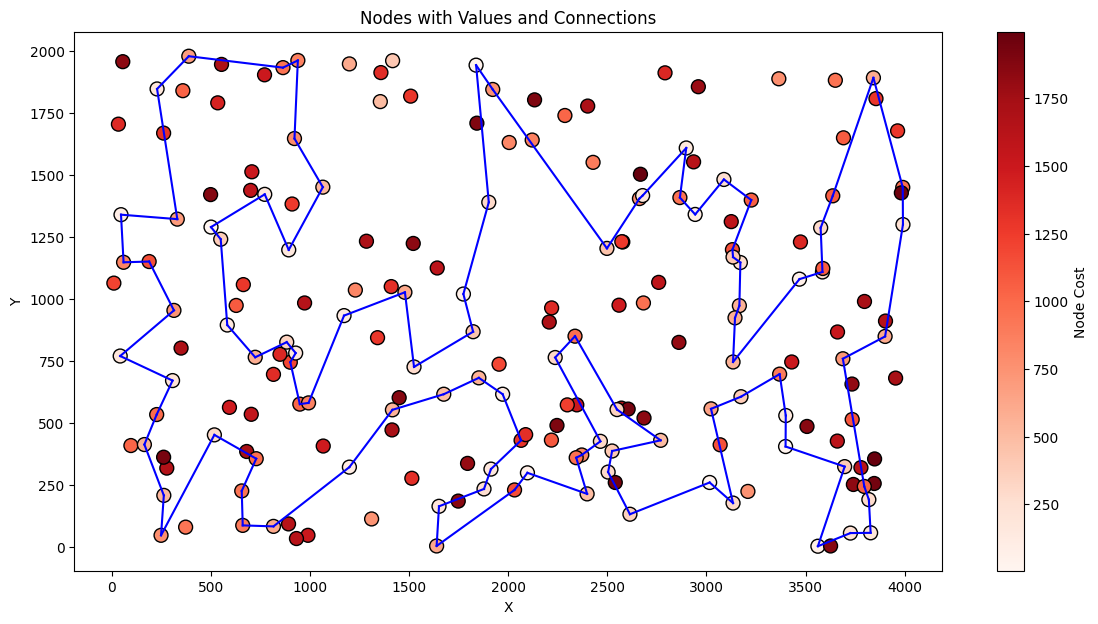

Achieved Total Score: 74164


In [8]:
def update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Calculates the score after changing the node with an outside node in remaining_nodes. Only used when a new move appears.
    '''
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position - 1]
    node_after = solution[(cycle_position + 1) % num_cycle_nodes]
    score -= distance_matrix[node_1][node_before]
    score -= distance_matrix[node_1][node_after]
    score -= weights[node_1]
    score += distance_matrix[node_2][node_before]
    score += distance_matrix[node_2][node_after]
    score += weights[node_2]
    return score

def update_score_inter_edge_delta(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    '''
    Calculates the score after changing the solution by exchanging edges. Only used when a new move appears.
    '''
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score

def node_intra_change_steepest_fast_delta(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index):
    '''
    Calculates the new solution and score after applying a move by exchanging node with a node from remaining_nodes. Also updates indexes and sets.
    '''
    solution_set.remove(solution[cycle_position])
    solution_set.add(remaining_nodes[relative_node_position])
    remaining_nodes_set.add(solution[cycle_position])
    remaining_nodes_set.remove(remaining_nodes[relative_node_position])
    solution_index[remaining_nodes[relative_node_position]] = cycle_position
    remaining_nodes_index[solution[cycle_position]] = relative_node_position
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return score + move_score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index

def edge_inter_change_steepest_fast_delta(move_score, score, solution, cycle_position, any_node_position, solution_index):
    '''
    Calculates the new solution and score after applying a move by exchanging edges. Also updates indexes and sets.
    '''
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]
    for i in range(cycle_position + 1, any_node_position + 1):
        solution_index[solution[i]] = i
    return score + move_score, solution, solution_index

def get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights):
    '''
    Produces the initial moves.
    '''
    moves = SortedList()
    already_added_inter = set()
    already_added_edges = set()

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            temp_score = update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            node_before = solution[cycle_position - 1]
            node_after = solution[(cycle_position + 1) % num_cycle_nodes]
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after), 0)) # 0 for intra

        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            temp_score = update_score_inter_edge_delta(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1)) # 1 for inter

    return moves, already_added_inter, already_added_edges

def update_moves_intra_delta(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Updates moves after an echange of nodes.
    '''
    for relative_node_position in range(len(remaining_positions)):
        prev_node = solution[cycle_position - 1]
        next_node = solution[(cycle_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
            continue
        temp_score = update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
        move_score = temp_score - score
        already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    for any_node_position in range(cycle_position + 2, num_cycle_nodes):
        if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
            continue
        node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
        node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
            continue
        temp_score = update_score_inter_edge_delta(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
        move_score = temp_score - score
        already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))
        
    return moves, already_added_inter, already_added_edges

def update_moves_inter_edge_delta(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights):
    '''
    Updates the moves after an exchange of edges.
    '''
    for cycle_position in cycle_positions:
        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
                continue
            temp_score = update_score_inter_edge_delta(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            prev_node = solution[cycle_position - 1]
            next_node = solution[(cycle_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
                continue
            temp_score = update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    return moves, already_added_inter, already_added_edges

def init_index_dict(values):
    '''
    Creates a dictionary of of indexes for each value.
    '''
    index_dict = {}
    for i in range(len(values)):
        index_dict[values[i]] = i
    return index_dict

def deltas_steepest_local_search_edges(solution, score, distance_matrix, weights):
    num_cycle_nodes = len(solution)
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(num_cycle_nodes)]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    solution_set = set(solution)
    remaining_nodes_set = set(remaining_nodes)
    solution_index = init_index_dict(solution)
    remaining_nodes_index = init_index_dict(remaining_nodes)

    moves, already_added_inter, already_added_edges = get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights)
    i = 0
    while i < len(moves):
        move_score, move, inter = moves[i]
        if not inter:
            cycle_node, any_node, node_before, node_after = move
            if cycle_node not in solution_set or any_node not in remaining_nodes_set:
                moves.remove(moves[i])
                already_added_inter.remove(move)
                continue
            cycle_position = solution_index[cycle_node]
            if node_before != solution[cycle_position - 1] or node_after != solution[(cycle_position + 1) % num_cycle_nodes]:
                moves.remove(moves[i])
                already_added_inter.remove(move)
                continue
            relative_node_position = remaining_nodes_index[any_node]
            score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index = node_intra_change_steepest_fast_delta(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index)
            moves, already_added_inter, already_added_edges = update_moves_intra_delta(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            i = 0
        else:
            if move[0] not in solution_set or move[1] not in solution_set:
                moves.remove(moves[i])
                already_added_edges.remove(move)
                continue
            cycle_node, any_node, node_after_cycle, node_after_any = move
            cycle_position = solution_index[cycle_node]
            any_node_position = solution_index[any_node]
            if cycle_position > any_node_position:
                i += 1
                continue # We got turned around ;(
            if node_after_cycle != solution[(cycle_position + 1) % num_cycle_nodes] or node_after_any != solution[(any_node_position + 1) % num_cycle_nodes]:
                moves.remove(moves[i])
                already_added_edges.remove(move)
                continue
            score, solution, solution_index = edge_inter_change_steepest_fast_delta(move_score, score, solution, cycle_position, any_node_position, solution_index)
            moves, already_added_inter, already_added_edges = update_moves_inter_edge_delta(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights)
            i = 0

    return solution, score

start_time = time.time()
for i in range(10):
    random_solution_result, random_solutionscore = random_solution(distance_matrix, weights, start_node = i)
    random_solution_result, random_solutionscore = deltas_steepest_local_search_edges(random_solution_result, random_solutionscore, distance_matrix, weights)
end_time = time.time()


print(f"Total time for 10 solutions: {end_time - start_time}")
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = deltas_steepest_local_search_edges(start_solution, start_score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Achieved Total Score: {score}")

## Insertion score update from greedy

In [9]:
def update_insert_score(solution, score, node, insert_location, matrix, weights):
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score


## LNS

In [10]:
def Large_Neighborhood_Search(distance_matrix, weights, initial_algorithm, steepest_algorithm, \
                              num_nodes, allowed_time, destroy, repair, optional_steepest = True, df = None, \
                                num_destroy_nodes=30):
    start_time = time.time()
    end_time = start_time
    random_start = np.random.randint(0, num_nodes)
    current_solution, current_score = initial_algorithm(distance_matrix, weights, start_node=random_start)
    current_solution, current_score = steepest_algorithm(current_solution, current_score, distance_matrix, weights)
    best_solution = current_solution.copy()
    best_score = current_score
    num_iterations = 0
    while (end_time - start_time) < allowed_time:
        num_iterations += 1
        current_solution, current_score, removed_nodes = destroy(current_solution, current_score,\
                                                        distance_matrix, weights, \
                                                        num_total_nodes = num_nodes, \
                                                        num_destroy_nodes = num_destroy_nodes)
        current_solution, current_score = repair(current_solution, current_score, \
                                                 removed_nodes, distance_matrix, weights, num_destroy_nodes, df=df)
        # print(best_score, current_score)    
        if optional_steepest:
            current_solution, current_score = steepest_algorithm(current_solution, current_score, distance_matrix, weights)
            # print(current_score)

        if current_score < best_score:
            best_score = current_score
            best_solution = current_solution.copy()
        else:
            current_score = best_score
            current_solution = best_solution.copy()
        
        end_time = time.time()
        
        # break
    
    return best_solution, best_score, num_iterations

## Destroy

In [11]:
def destroy(current_solution, current_score, distance_matrix, weights, num_total_nodes, num_destroy_nodes):
    start_node = np.random.randint(0, num_total_nodes - 1)
    end_node = start_node + num_destroy_nodes
    
    current_score -= distance_matrix[current_solution[start_node - 1]][current_solution[start_node]]
    current_score -= distance_matrix[current_solution[(end_node-1)%num_total_nodes]][current_solution[end_node%num_total_nodes]]
    current_score += distance_matrix[current_solution[end_node%num_total_nodes]][current_solution[start_node-1]]

    if end_node >= num_total_nodes:
        removed_nodes = current_solution[start_node:] + current_solution[:end_node % num_total_nodes]
        
        current_score -= np.sum(distance_matrix[removed_nodes[:-1], removed_nodes[1:]])
        current_score -= np.sum(weights[removed_nodes])
        
        current_solution = np.array(current_solution)
        current_solution = np.delete(current_solution, list(range(start_node, num_total_nodes)) \
                                      + list(range(0, end_node % num_total_nodes)))
        current_solution = list(current_solution)
        # print("E")

    else:
        removed_nodes = current_solution[start_node:end_node]
        # print(len(removed_nodes))

        current_score -= np.sum(distance_matrix[removed_nodes[:-1], removed_nodes[1:]])
        current_score -= np.sum(weights[removed_nodes])
        
        del current_solution[start_node:end_node]

    # print(current_score, calculate_score(current_solution, distance_matrix, weights), len(current_solution))
    return current_solution, current_score, removed_nodes

# Repair

In [12]:
def repair_nn_all(current_solution, current_score, removed_nodes, matrix, weights, num_destroy_nodes, df=None):
    available_nodes = set(range(len(weights))) - set(current_solution)
    while num_destroy_nodes > 0:
        best_score = np.inf
        best_node = None
        best_location = None
        
        for node in list(available_nodes):
            score_locations = []
            scores = []
        
            for insert_location in range(len(current_solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_insert_score(current_solution, current_score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
        
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
        
            if scores[0] < best_score:
                best_node = node
                best_location = score_locations[0]
                best_score = scores[0]
        
        current_solution.insert(best_location, best_node)
        current_score = best_score
        available_nodes.remove(best_node)
        num_destroy_nodes -= 1
    
    return current_solution, current_score

def repair_nn_all_removed(current_solution, current_score, removed_nodes, matrix, weights, df=None):
    # plot_nodes_with_lines(df, current_solution, cycle=False)
    # print(current_score, calculate_score(current_solution, matrix, weights), len(current_solution))
    while len(removed_nodes) > 0:
        best_score = np.inf
        best_node = None
        best_location = None
        
        for node in removed_nodes:
            score_locations = []
            scores = []
        
            for insert_location in range(len(current_solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_insert_score(current_solution, current_score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
        
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
        
            if scores[0] < best_score:
                best_node = node
                best_location = score_locations[0]
                best_score = scores[0]
        
        current_solution.insert(best_location, best_node)
        current_score = best_score
        removed_nodes.remove(best_node)

    # plot_nodes_with_lines(df, current_solution)

    # print(current_score, calculate_score(current_solution, matrix, weights), len(current_solution))
    # current_score = calculate_score(current_solution, matrix, weights)
    # print(current_score)
    
    return current_solution, current_score


def repair_weighted_regret(current_solution, current_score, removed_nodes, matrix, weights, \
                            num_destroy_nodes, df=None, regret_weight=-0.5):
    
    available_nodes = set(range(len(weights))) - set(current_solution)
    while num_destroy_nodes > 0:
        best_weighted_score = np.inf
        best_score = None
        best_node = None
        best_location = None
                
        for node in list(available_nodes):
            score_locations = []
            scores = []
        
            for insert_location in range(len(current_solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_insert_score(current_solution, current_score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
        
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            score_difference = scores[0] - current_score
            weghted_score = ((1 + regret_weight) * score_difference) + (regret_weight * regret)
        
            if weghted_score < best_weighted_score:
                best_weighted_score = weghted_score
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        
        current_solution.insert(best_location, best_node)
        current_score = best_score
        available_nodes.remove(best_node)
        num_destroy_nodes -= 1

    return current_solution, current_score

## Run

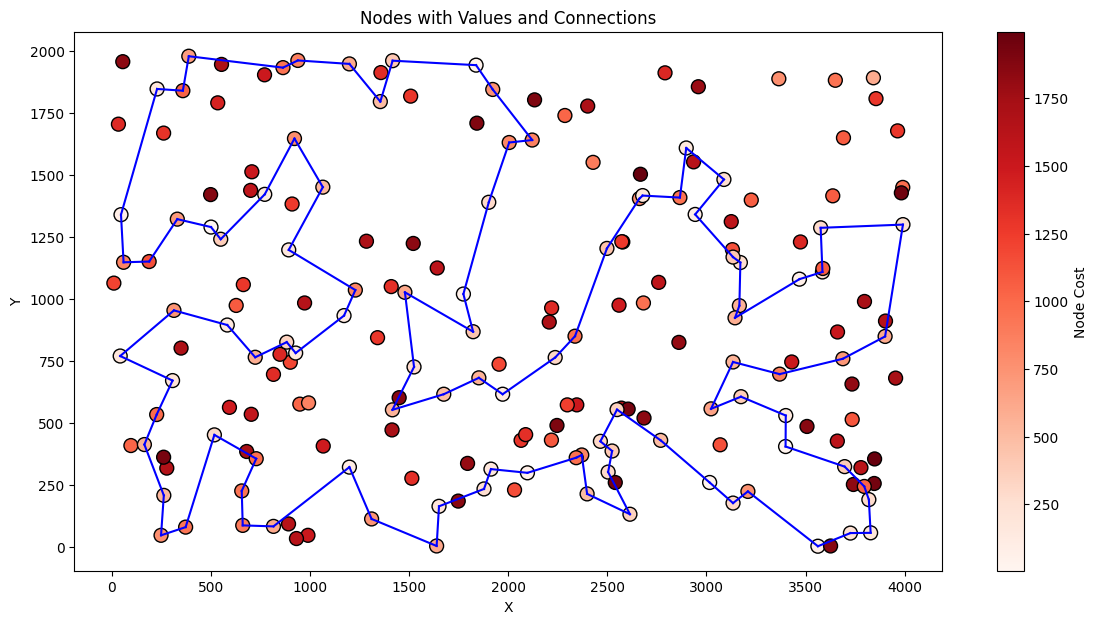

Achieved Total Score: 69340
Number of iterations: 378


In [13]:
allowed_time = 97.98816983699798
# allowed_time = 20

solution, score, iterations = Large_Neighborhood_Search(distance_matrix, weights, initial_algorithm=random_solution, \
                                                        steepest_algorithm=deltas_steepest_local_search_edges, \
                                                        num_nodes=len(weights)//2, allowed_time=allowed_time, \
                                                        destroy=destroy, repair=repair_weighted_regret, \
                                                        optional_steepest=True, df=df)
plot_nodes_with_lines(df, solution)
print(f"Achieved Total Score: {score}")
print(f"Number of iterations: {iterations}")

## Experiments

In [14]:
def test_many_nls(algorithm, num_tests, *args, **kwargs):
    scores = []
    solutions = []
    iterations = []
    for _ in range(num_tests):
        solution, score, num_iterations = algorithm(*args, **kwargs)
        scores.append(score)
        solutions.append(solution)
        iterations.append(num_iterations)
    return scores, solutions, iterations

In [15]:
msls_time = 97.98816983699798

### TSPA

In [16]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix_A = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()
weights_A[:2]

array([496, 414], dtype=int64)

#### With LS

Iterations: [381, 390, 385, 386, 366, 376, 396, 392, 401, 394, 392, 394, 394, 379, 375, 389, 393, 386, 382, 394]
Mean score: 69457.2
Min score: 69207
Max score: 69821


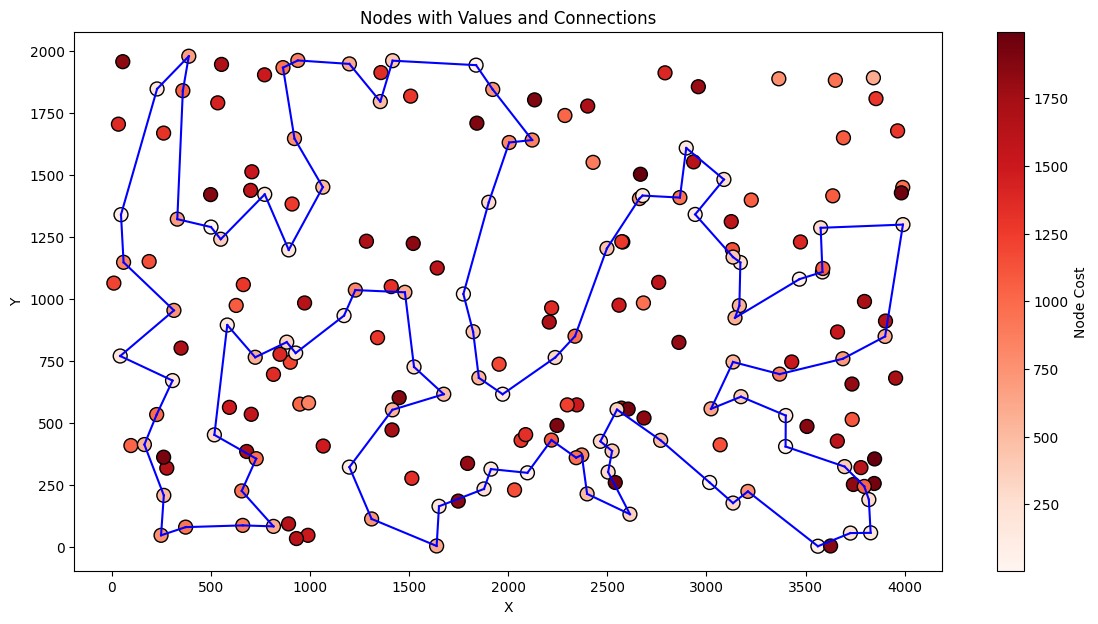

[42, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 129, 57, 179, 196, 81, 90, 165, 40, 185, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 35, 184]


In [17]:
scores_ls, solutions_ls, iterations_ls = test_many_nls(Large_Neighborhood_Search, 20, distance_matrix_A, weights_A, random_solution, deltas_steepest_local_search_edges, \
                                              len(weights_A)//2, msls_time, destroy, repair_weighted_regret, \
                                            optional_steepest=True, num_destroy_nodes=30)
temp_scores_ls = np.array(scores_ls)
print(f"Iterations: {iterations_ls}")
print(f"Mean score: {temp_scores_ls.mean()}")
print(f"Min score: {temp_scores_ls.min()}")
print(f"Max score: {temp_scores_ls.max()}")
best_arg_ls = np.argmin(temp_scores_ls)
best_solution_ls = solutions_ls[best_arg_ls]
plot_nodes_with_lines(df_A, best_solution_ls)
print(best_solution_ls)

In [19]:
print(f"Mean iterations {np.mean(iterations_ls)}")

Mean iterations 387.25


#### Without LS

Iterations: [419, 425, 424, 418, 421, 419, 396, 387, 385, 397, 392, 408, 418, 402, 392, 390, 395, 396, 392, 385]
Mean iterations 403.05
Mean score: 69640.45
Min score: 69250
Max score: 70805


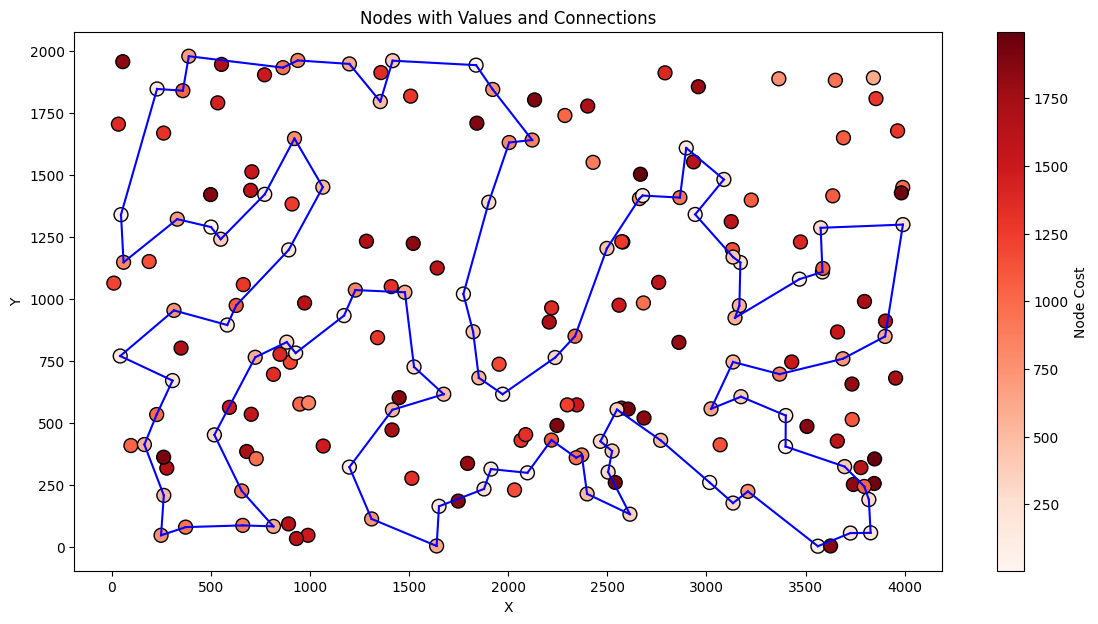

[186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 178, 106, 52, 55, 185, 40, 165, 90, 81, 196, 179, 57, 129, 92, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 65, 116, 43, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 42, 5, 115, 46, 68, 139, 41, 193, 159, 146, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89]


In [20]:
scores, solutions, iterations = test_many_nls(Large_Neighborhood_Search, 20, distance_matrix_A, weights_A, random_solution, deltas_steepest_local_search_edges, \
                                              len(weights_A)//2, msls_time, destroy, repair_weighted_regret, \
                                            optional_steepest=False, num_destroy_nodes=30)
temp_scores = np.array(scores)
print(f"Iterations: {iterations}")
print(f"Mean iterations {np.mean(iterations)}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
print(f"Max score: {temp_scores.max()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df_A, best_solution)
print(best_solution)

### TSPB

In [21]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()
weights_B[:2]

array([ 40, 247], dtype=int64)

#### With LS

Iterations: [351, 355, 355, 352, 359, 355, 359, 357, 358, 361, 354, 359, 357, 354, 356, 374, 360, 358, 360, 352]
Mean iterations 357.3
Mean score: 44132.5
Min score: 43873
Max score: 44463


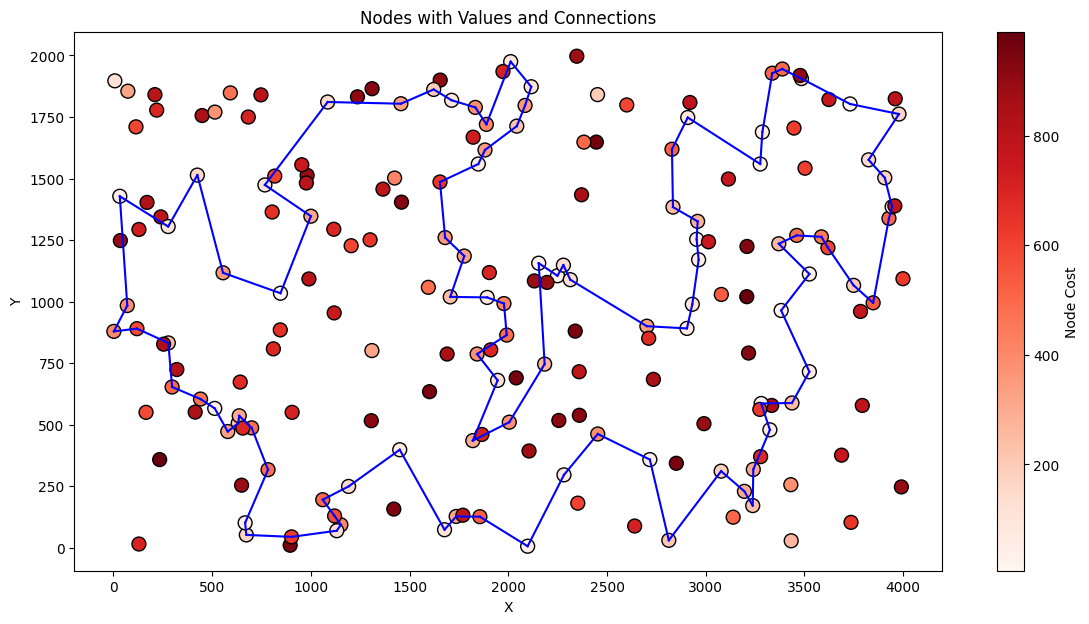

[33, 160, 144, 104, 8, 21, 82, 111, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 172, 179, 22, 99, 130, 95, 185, 86, 166, 194, 176, 113, 103, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 177, 5, 45, 142, 78, 175, 162, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 16, 27, 38, 63, 135, 122, 131, 121, 51, 90, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 43, 139, 11, 138]


In [22]:
scores_ls, solutions_ls, iterations_ls = test_many_nls(Large_Neighborhood_Search, 20, distance_matrix_B, weights_B, random_solution, deltas_steepest_local_search_edges, \
                                              len(weights_B)//2, msls_time, destroy, repair_weighted_regret, \
                                            optional_steepest=True, num_destroy_nodes=30)
temp_scores_ls = np.array(scores_ls)
print(f"Iterations: {iterations_ls}")
print(f"Mean iterations {np.mean(iterations_ls)}")
print(f"Mean score: {temp_scores_ls.mean()}")
print(f"Min score: {temp_scores_ls.min()}")
print(f"Max score: {temp_scores_ls.max()}")
best_arg_ls = np.argmin(temp_scores_ls)
best_solution_ls = solutions_ls[best_arg_ls]
plot_nodes_with_lines(df_B, best_solution_ls)
print(best_solution_ls)

#### Without LS

Iterations: [391, 390, 383, 387, 384, 378, 399, 398, 388, 403, 395, 379, 386, 378, 384, 391, 413, 412, 391, 391]
Mean iterations 391.05
Mean score: 44361.05
Min score: 44174
Max score: 44657


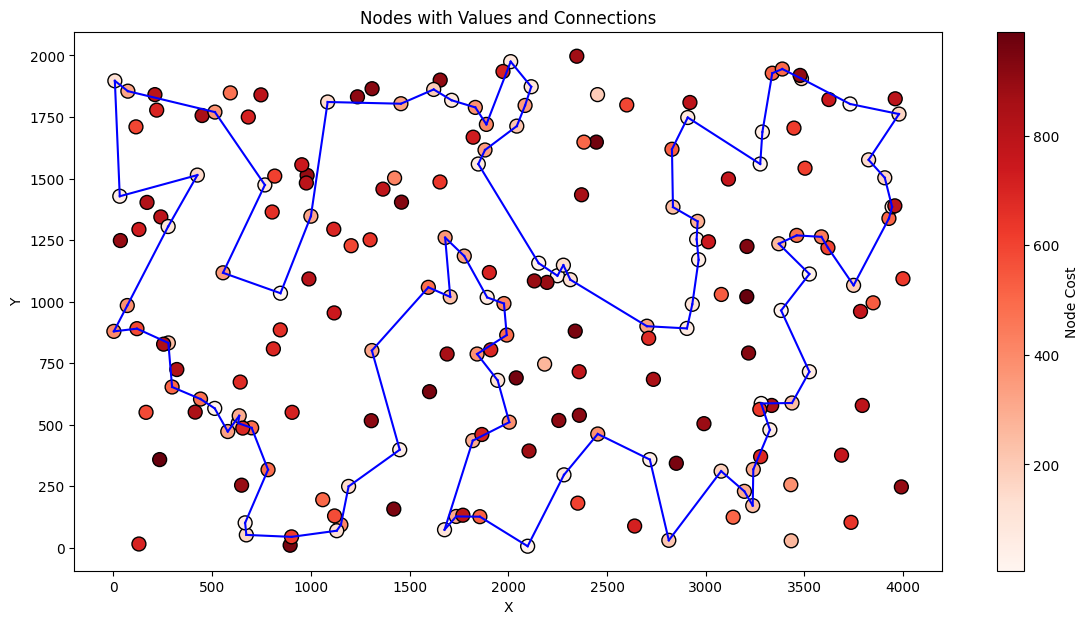

[193, 54, 31, 73, 136, 190, 80, 162, 175, 78, 5, 177, 25, 182, 138, 139, 11, 33, 160, 144, 104, 8, 82, 21, 36, 61, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 51, 121, 131, 90, 133, 107, 40, 63, 122, 135, 38, 27, 16, 1, 156, 198, 117]


In [23]:
scores, solutions, iterations = test_many_nls(Large_Neighborhood_Search, 20, distance_matrix_B, weights_B, random_solution, deltas_steepest_local_search_edges, \
                                              len(weights_B)//2, msls_time, destroy, repair_weighted_regret, \
                                            optional_steepest=False, num_destroy_nodes=30)
temp_scores = np.array(scores)
print(f"Iterations: {iterations}")
print(f"Mean iterations {np.mean(iterations)}")
print(f"Mean score: {temp_scores.mean()}")
print(f"Min score: {temp_scores.min()}")
print(f"Max score: {temp_scores.max()}")
best_arg = np.argmin(temp_scores)
best_solution = solutions[best_arg]
plot_nodes_with_lines(df_B, best_solution)
print(best_solution)